In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from collections import defaultdict
import torch
from pyrocov import mutrans
import pickle

### Compute clade birthdays

In [2]:
results_dir = '../results/'
columns = pickle.load(open(results_dir + 'columns.3000.pkl', 'rb'))
assert len(set(columns['clade'])) == 2999

def estimate_clade_bdays(exclude_first=10, min_portion=0.0005, max_portion=0.1):
    clade_days = defaultdict(list)
    for clade, day in zip(columns["clade"], columns["day"]):
        clade_days[clade].append(day)
    clade_bday = {}
    for clade, days in list(clade_days.items()):
        days.sort()
        exclude = max(exclude_first, int(min_portion * len(days)))
        exclude = min(exclude, int(max_portion * len(days)))
        clade_bday[clade] = days[exclude]
    start_date = datetime.datetime.strptime(mutrans.START_DATE, "%Y-%m-%d")
    return {
        clade: (start_date + datetime.timedelta(days=day))
        for clade, day in clade_bday.items()
    }

clade_bday = estimate_clade_bdays()
print(len(clade_bday))

2999


## Compare S-gene to RBD to non-S

In [3]:
filename = 'mutrans.svi.3000.1.50.coef_scale=0.05.reparam-localinit.full.10001.0.05.0.1.10.0.200.6.None..pt'
fit = torch.load(results_dir + filename, map_location=torch.device('cpu'))

coef = fit['median']['coef'].data.cpu()

features = torch.load(results_dir + 'features.3000.1.pt', map_location=torch.device('cpu'))

clades = features['clades']
clade_to_lineage = features['clade_to_lineage']
mutations = features['aa_mutations']
features = features['aa_features'].data.cpu().float()

full_pred = torch.mv(features, coef).data.numpy()
print("full_pred", full_pred.shape)

rbd = []
S = []
for m in mutations:
    if m[:2] != 'S:':
        rbd.append(0)
        S.append(0)
        continue

    S.append(1)

    pos = int(m[3:-1])

    if pos >= 319 and pos <= 541:
        rbd.append(1)
    else:
        rbd.append(0)

S = torch.tensor(S).bool()
rbd = torch.tensor(rbd).bool()

S_mutations = np.array(mutations)[S].tolist()
rbd_mutations = np.array(mutations)[rbd].tolist()

S_features = features[:, S]
rbd_features = features[:, rbd]
print("S_features", S_features.shape)
print("rbd_features", rbd_features.shape)

S_coef = coef[S]
rbd_coef = coef[rbd]
print("S_coef", S_coef.shape)
print("rbd_coef", rbd_coef.shape)

S_pred = torch.mv(S_features, S_coef).data.numpy()
rbd_pred = torch.mv(rbd_features, rbd_coef).data.numpy()
print("S_pred", S_pred.shape)
print("rbd_pred", rbd_pred.shape)

full_pred (3000,)
S_features torch.Size([3000, 415])
rbd_features torch.Size([3000, 68])
S_coef torch.Size([415])
rbd_coef torch.Size([68])
S_pred (3000,)
rbd_pred (3000,)


In [4]:
full_pred = 0.01 * full_pred
rbd_pred = 0.01 * rbd_pred
S_pred = 0.01 * S_pred

missing_clade = 'fine.521.0...1284.0.32.219.3.50.116'

mask = []
for clade in clades:
    if clade == missing_clade:
        mask.append(0)
    else:
        mask.append(1)
mask = np.array(mask, dtype=bool)

dates = []

for clade in clades:
    if clade in clade_bday:
        dates.append(clade_bday[clade])
    else:
        dates.append(None)
        
dates = np.array(dates)[mask].tolist()
full_pred = full_pred[mask]
rbd_pred = rbd_pred[mask]
S_pred = S_pred[mask]
    
assert len(dates) == len(full_pred) == len(rbd_pred) == len(S_pred) == 2999

print(dates[:2])

[datetime.datetime(2019, 12, 30, 0, 0), datetime.datetime(2020, 4, 1, 0, 0)]


In [5]:
from collections import OrderedDict

def aggregate_by_month(values, dates):
    agg = defaultdict(list)
    for v, d in zip(values, dates):
        d = datetime.datetime(d.year, d.month, 1)
        agg[d].append(v)
        
    mean = OrderedDict()
    for v, k in agg.items():
        mean[v] = np.median(k)
        
    return list(mean.keys()), list(mean.values())        

y-mins: -0.006676604 -0.00018717974 -0.20632032
y-maxes: 1.3910034 0.90480256 0.8389287


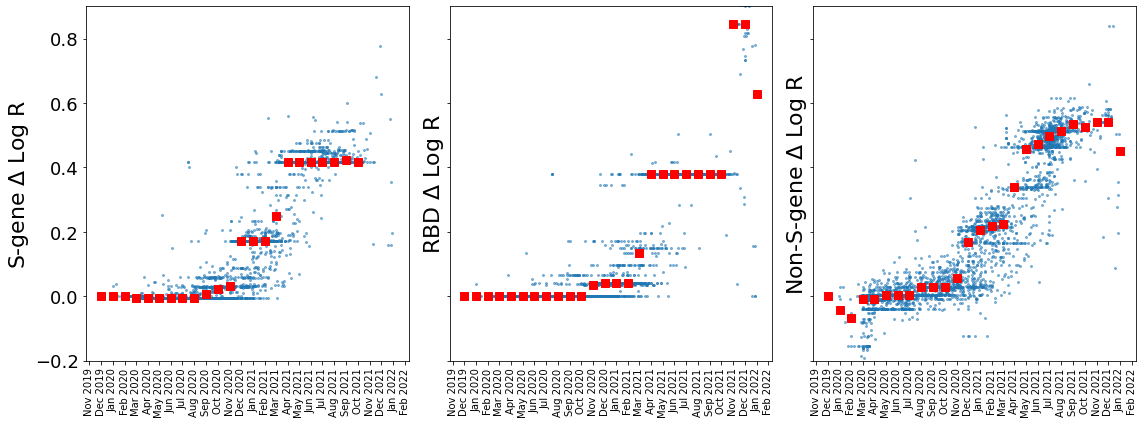

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(16, 6))

print("y-mins:", min(S_pred), min(rbd_pred), min(full_pred - S_pred))
print("y-maxes:", max(S_pred), max(rbd_pred), max(full_pred - S_pred))

labelfontsize = 22

ax0.plot(dates, S_pred, lw=0.0, ls=None, marker='.', alpha=0.5, markersize=4)
months, values = aggregate_by_month(S_pred, dates)
ax0.plot(months, values, lw=0.0, ls=None, color='red', marker='s', markersize=8)
ax0.set_ylabel("S-gene $\\Delta$ Log R", fontsize=labelfontsize)

ax1.plot(dates, rbd_pred, lw=0.0, ls=None, marker='.', alpha=0.5, markersize=4)
months, values = aggregate_by_month(rbd_pred, dates)
ax1.plot(months, values, lw=0.0, ls=None, color='red', marker='s', markersize=8)
ax1.set_ylabel("RBD $\\Delta$ Log R", fontsize=labelfontsize)

ax2.plot(dates, full_pred - S_pred, lw=0.0, ls=None, marker='.', alpha=0.5, markersize=4)
months, values = aggregate_by_month(full_pred - S_pred, dates)
ax2.plot(months, values, lw=0.0, ls=None, color='red', marker='s', markersize=8)
ax2.set_ylabel("Non-S-gene $\\Delta$ Log R", fontsize=labelfontsize)

for ax in (ax0, ax1, ax2):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.set_ylim(-0.2, 0.9)
    
    for label in ax.get_xticklabels():
        label.set_rotation(90)

ax0.tick_params(axis='y', which='major', labelsize=18)

plt.tight_layout()
plt.savefig('delta_logR_breakdown.png')
plt.show()

### examine b.1.1 heterogeneity

In [7]:
lineage_to_clades = defaultdict(list)
for k, v in clade_to_lineage.items():
    lineage_to_clades[v].append(k)
clade_ids = {clade: i for i, clade in enumerate(clades)}

In [9]:
b11 = []
for clade in lineage_to_clades['B.1.1']:
    b11.append( (clade_bday[clade], full_pred[clade_ids[clade]] ) )

In [10]:
sorted(b11)

[(datetime.datetime(2020, 2, 25, 0, 0), -0.0020685028),
 (datetime.datetime(2020, 2, 29, 0, 0), -0.0020685028),
 (datetime.datetime(2020, 3, 1, 0, 0), -0.007830757),
 (datetime.datetime(2020, 3, 1, 0, 0), -0.0020685028),
 (datetime.datetime(2020, 3, 11, 0, 0), -0.004205396),
 (datetime.datetime(2020, 3, 15, 0, 0), 0.012762796),
 (datetime.datetime(2020, 3, 18, 0, 0), 0.02507452),
 (datetime.datetime(2020, 4, 1, 0, 0), 0.04511804),
 (datetime.datetime(2020, 4, 7, 0, 0), 0.04073237),
 (datetime.datetime(2020, 4, 20, 0, 0), 0.04775856),
 (datetime.datetime(2020, 5, 12, 0, 0), 0.042780522),
 (datetime.datetime(2020, 6, 3, 0, 0), 0.26968765),
 (datetime.datetime(2020, 7, 27, 0, 0), 0.13128623),
 (datetime.datetime(2020, 10, 24, 0, 0), 0.07634191),
 (datetime.datetime(2020, 12, 15, 0, 0), 0.006523318),
 (datetime.datetime(2020, 12, 21, 0, 0), 0.118256964),
 (datetime.datetime(2021, 1, 14, 0, 0), 0.08020903),
 (datetime.datetime(2021, 1, 28, 0, 0), 0.08020903),
 (datetime.datetime(2021, 2, 2,